# PR-0019
### Sales Effectiveness ML
#### Team Members: Prabhati Acharya and Vivek Viswanathan

## Business Goal

FicZonInc is an IT solution provider with products ranging from on-premises products to SAAS based solutions. FicZon major leads generation channel is digital and through their website. FicZon business is majorly dependent on the sales force effectiveness. As the market is maturing and more new competitors entering the market, FicZon is experiencing the dip in sales. Effective sales is dependent on lead quality and as of now, this is based on manual categorization and highly depended on sales staff. Though there is a quality process, which continuously updates the lead categorization, it’s value is in for post analysis, rather than conversation.FicZonwants to explore Machine Learning to pre-categorize the lead quality and as result, expecting significant increase in sales effectiveness.

### Project Goal

1. Data exploration insights – Sales effectiveness.
2. ML model to predict the Lead Category(High Potential , Low Potential)

##### Import the necessary packages

In [1]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from pandas_profiling import ProfileReport
from IPython.display import Image
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO
import graphviz
import matplotlib.image as mpimg
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import itertools
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.feature_selection import RFECV
from vecstack import stacking
from mlxtend.classifier import StackingCVClassifier
from mlxtend.plotting import plot_learning_curves, plot_decision_regions
#from sklearn.pipeline import Pipeline
#from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV



import warnings
warnings.simplefilter('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
rand_state = 10
n_iterations = 5

In [3]:
db_host='54.255.64.49'
username='dm_team2'
user_pass='DM!$Team&27@9!20!'
db_name='project_sales'

In [4]:
conn = pymysql.connect(host=db_host, port=int(3306), user=username, passwd=user_pass, db=db_name)

In [5]:
product_sales_data=pd.read_sql_query("SELECT * FROM data", conn)
product_sales_data.head()

,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
0,14-11-2018 10:05,,Website,984XXXXXXX,aXXXXXXX@gmail.com,Sales-Agent-11,,Mode-5,Open
1,14-11-2018 09:22,,Website,XXXXXXX,#VALUE!,Sales-Agent-10,,Mode-5,Open
2,14-11-2018 09:21,,Website,XXXXXXX,dXXXXXXX@yahoo.com,Sales-Agent-10,,Mode-5,Open
3,14-11-2018 08:46,,Website,XXXXXXX,wXXXXXXX@gmail.com,Sales-Agent-10,,Mode-5,Open
4,14-11-2018 07:34,,Website,XXXXXXX,cXXXXXXX@gmail.com,Sales-Agent-10,,Mode-5,Open


### EDA of the dataset

Perform the following exploratory data analysis on the dataset
- Shape of the dataset
- Info to get column names, number of not null count and data type
- Null Count
- Count of distinct values for each column
- The distinct values and the counts for the categorical variables

In [6]:
product_sales_data.to_csv('Sales_data.csv')

product_sales_data

product_sales_data=pd.read_csv('Sales_data.csv')

In [7]:
product_sales_data.shape

(7422, 10)

In [8]:
product_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     7422 non-null   int64  
 1   Created        7422 non-null   object 
 2   Product_ID     7364 non-null   float64
 3   Source         7405 non-null   object 
 4   Mobile         5612 non-null   object 
 5   EMAIL          7422 non-null   object 
 6   Sales_Agent    7399 non-null   object 
 7   Location       7364 non-null   object 
 8   Delivery_Mode  7422 non-null   object 
 9   Status         7422 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 580.0+ KB


In [9]:
product_sales_data.columns

Index(['Unnamed: 0', 'Created', 'Product_ID', 'Source', 'Mobile', 'EMAIL',
       'Sales_Agent', 'Location', 'Delivery_Mode', 'Status'],
      dtype='object')

#### Converting email and mobile columns to categorical variables

Since the email ID and mobile numbers are not going to add additional value to the analysis, instead of dropping the features, we would be converting them to boolean values of whether a valid email id is provided or not and if a mobile number is provided or not. 

This, in our opinion, would be more valueable than the actual values in these columns.

In [10]:
product_sales_data.EMAIL.replace(['#VALUE!'],0,inplace=True)
product_sales_data.EMAIL = product_sales_data.EMAIL.astype(bool).astype(int)

In [11]:
product_sales_data.Mobile.replace(np.nan,0,inplace=True)
product_sales_data.Mobile = product_sales_data.Mobile.astype(bool).astype(int)

In [12]:
product_sales_data.head()

,Unnamed: 0,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
0,0,14-11-2018 10:05,NaN,Website,1,1,Sales-Agent-11,NaN,Mode-5,Open
1,1,14-11-2018 09:22,NaN,Website,1,0,Sales-Agent-10,NaN,Mode-5,Open
2,2,14-11-2018 09:21,NaN,Website,1,1,Sales-Agent-10,NaN,Mode-5,Open
3,3,14-11-2018 08:46,NaN,Website,1,1,Sales-Agent-10,NaN,Mode-5,Open
4,4,14-11-2018 07:34,NaN,Website,1,1,Sales-Agent-10,NaN,Mode-5,Open


#### Drop Unique and timestamp columns

We have dropped the columns:
- Unnamed: 0 - Identity column
- Created - Timestamp column
- Product ID - The product identifier usually is unique and does not add value to the analysis.

In [13]:
product_sales_data.drop(columns=['Unnamed: 0', 'Product_ID', 'Created'], axis=1, inplace=True)

In [14]:
product_sales_data.isnull().sum()

Source           17
Mobile            0
EMAIL             0
Sales_Agent      23
Location         58
Delivery_Mode     0
Status            0
dtype: int64

In [15]:
Catvar_list=['EMAIL', 'Mobile', 'Source', 'Sales_Agent', 'Location', 'Delivery_Mode', 'Status']

#### Data Imputation

We create a heat map to view how NaN values are distributed on the remaining variables.

##### Imputation Strategy:

For the remaining features, we will imputate using mode values.

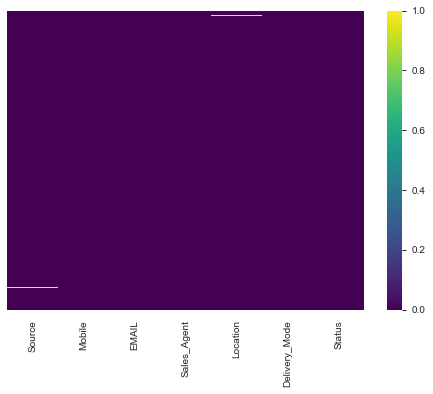

In [16]:
sns.set_style('whitegrid')
sns.heatmap(product_sales_data.isnull(),yticklabels=False,cbar=True,cmap='viridis')

In [17]:
product_sales_data[Catvar_list] = product_sales_data[Catvar_list].fillna(product_sales_data[Catvar_list].mode().iloc[0])

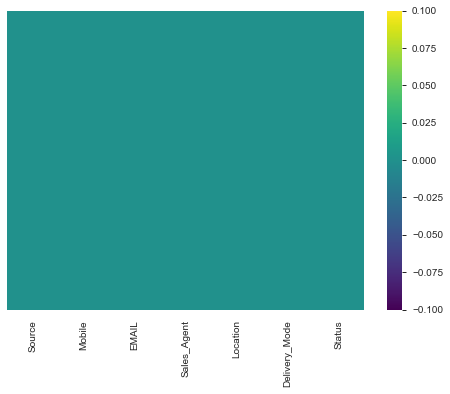

In [18]:
sns.set_style('whitegrid')
sns.heatmap(product_sales_data.isnull(),yticklabels=False,cbar=True,cmap='viridis')

In [19]:
product_sales_data.nunique(dropna=False)

Source           25
Mobile            2
EMAIL             2
Sales_Agent      12
Location         17
Delivery_Mode     5
Status           11
dtype: int64

In [20]:
product_sales_data[Catvar_list]

,EMAIL,Mobile,Source,Sales_Agent,Location,Delivery_Mode,Status
0,1,1,Website,Sales-Agent-11,Other Locations,Mode-5,Open
1,0,1,Website,Sales-Agent-10,Other Locations,Mode-5,Open
2,1,1,Website,Sales-Agent-10,Other Locations,Mode-5,Open
3,1,1,Website,Sales-Agent-10,Other Locations,Mode-5,Open
4,1,1,Website,Sales-Agent-10,Other Locations,Mode-5,Open
...,...,...,...,...,...,...,...
7417,1,0,Call,Sales-Agent-6,Mumbai,Mode-4,LOST
7418,0,0,Call,Sales-Agent-12,Other Locations,Mode-5,LOST
7419,1,0,Live Chat-Direct,Sales-Agent-11,Bangalore,Mode-1,Not Responding
7420,1,0,CRM form,Sales-Agent-4,Other Locations,Mode-1,Just Enquiry


#### Translating the target variable to High and Low Potential

We convert the target variable based on the below logic:
- CONVERTED','converted','In Progress Positive','Potential','Long Term','Open - __High Potential__
- 'LOST','In Progress Negative','Not Responding','Junk Lead','Just Enquiry - __Low Potential__

In [21]:
product_sales_data.Status.replace(['CONVERTED','converted','In Progress Positive','Potential','Long Term','Open'],'High Potential',inplace=True)
product_sales_data.Status.replace(['LOST','In Progress Negative','Not Responding','Junk Lead','Just Enquiry'],'Low Potential',inplace=True)

##### Print distinct values and the counts for the categorical variables

In [22]:
for cat in Catvar_list:
    print('\nUnique values of Product Sales Data.'+cat+':: \n',product_sales_data[cat].value_counts(dropna = False))


Unique values of Product Sales Data.EMAIL:: 
 1    5721
0    1701
Name: EMAIL, dtype: int64

Unique values of Product Sales Data.Mobile:: 
 1    5612
0    1810
Name: Mobile, dtype: int64

Unique values of Product Sales Data.Source:: 
 Call                             2564
Live Chat-Direct                 1834
Website                          1594
Live Chat-Google Organic          274
Live Chat -PPC                    249
Live Chat-Blog                    237
Customer Referral                 180
US Website                        137
Just Dial                          56
Existing Client                    51
Live Chat-CPC                      50
Personal Contact                   50
By Recommendation                  32
CRM form                           23
Existing Customer                  22
Live Chat-Google Ads               21
Campaign                           19
E-mail Campaign                    12
Live Chat-Adwords Remarketing       7
SMS Campaign                        2
Othe

### Encoding Categorical Variables

We will proceed to encode all the variables with __object__ data type. We will also store all the mapping between the Feature values and the corresponding encoded values in a dataframe so that we can refer back to it in order to explain the interactions between the features.

In [23]:
Catvar_list_enc=['Source', 'Sales_Agent', 'Location', 'Delivery_Mode', 'Status']

In [24]:
labelencoder = LabelEncoder()

In [25]:
product_sales_data_enc = product_sales_data

In [26]:
Feature_Code_Value = pd.DataFrame(columns=['Feature_Type', 'Feature_Value', 'Feature_Value_Enc', 'Feature_Value_Cnt'])

In [27]:
for feat in Catvar_list_enc:
    feat_col_name = feat+'_enc'
    product_sales_data_enc[feat_col_name] = labelencoder.fit_transform(product_sales_data_enc[feat].astype(str))
    feat_temp_val = product_sales_data_enc.groupby([feat, feat_col_name]).size().reset_index().rename(columns={0:'Feature_Value_Cnt'})
    feat_temp_val['Feature_Type'] = feat
    #feat_temp_val[['Feature_Type', feat, feat_col_name, 'Feature_Value_Cnt']]
    Feature_Code_Value = Feature_Code_Value[['Feature_Type', 'Feature_Value', 'Feature_Value_Enc', 'Feature_Value_Cnt']].append(feat_temp_val[['Feature_Type', feat, feat_col_name, 'Feature_Value_Cnt']])
    Feature_Code_Value.Feature_Value.fillna(Feature_Code_Value[feat], inplace=True)
    Feature_Code_Value.Feature_Value_Enc.fillna(Feature_Code_Value[feat_col_name], inplace=True)
    Feature_Code_Value.drop(columns=[feat, feat_col_name], axis=1, inplace=True)
    del feat_temp_val
    product_sales_data_enc.drop(columns=[feat], axis=1, inplace=True)
    
Feature_Code_Value.reset_index(drop=True, inplace=True)
Feature_Code_Value['Feature_Value_Enc'] = Feature_Code_Value['Feature_Value_Enc'].astype(int)

In [28]:
Feature_Code_Value

,Feature_Type,Feature_Value,Feature_Value_Enc,Feature_Value_Cnt
0,Source,By Recommendation,0,32
1,Source,CRM form,1,23
2,Source,Call,2,2564
3,Source,Campaign,3,19
4,Source,Customer Referral,4,180
...,...,...,...,...
56,Delivery_Mode,Mode-3,2,1688
57,Delivery_Mode,Mode-4,3,121
58,Delivery_Mode,Mode-5,4,2975
59,Status,High Potential,0,2931


### Distribution of the features

We next check the distribution of the categorical and continous variables. 

In [29]:
Catvar_list=['EMAIL', 'Mobile', 'Source_enc', 'Sales_Agent_enc', 'Location_enc', 'Delivery_Mode_enc', 'Status_enc']

product_sales_data_enc

,Mobile,EMAIL,Source_enc,Sales_Agent_enc,Location_enc,Delivery_Mode_enc,Status_enc
0,1,1,24,2,10,4,0
1,1,0,24,1,10,4,0
2,1,1,24,1,10,4,0
3,1,1,24,1,10,4,0
4,1,1,24,1,10,4,0
...,...,...,...,...,...,...,...
7417,0,1,2,8,9,3,1
7418,0,0,2,3,10,4,1
7419,0,1,14,2,1,0,1
7420,0,1,1,6,10,0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000136748CAF98>,
      dtype=object)

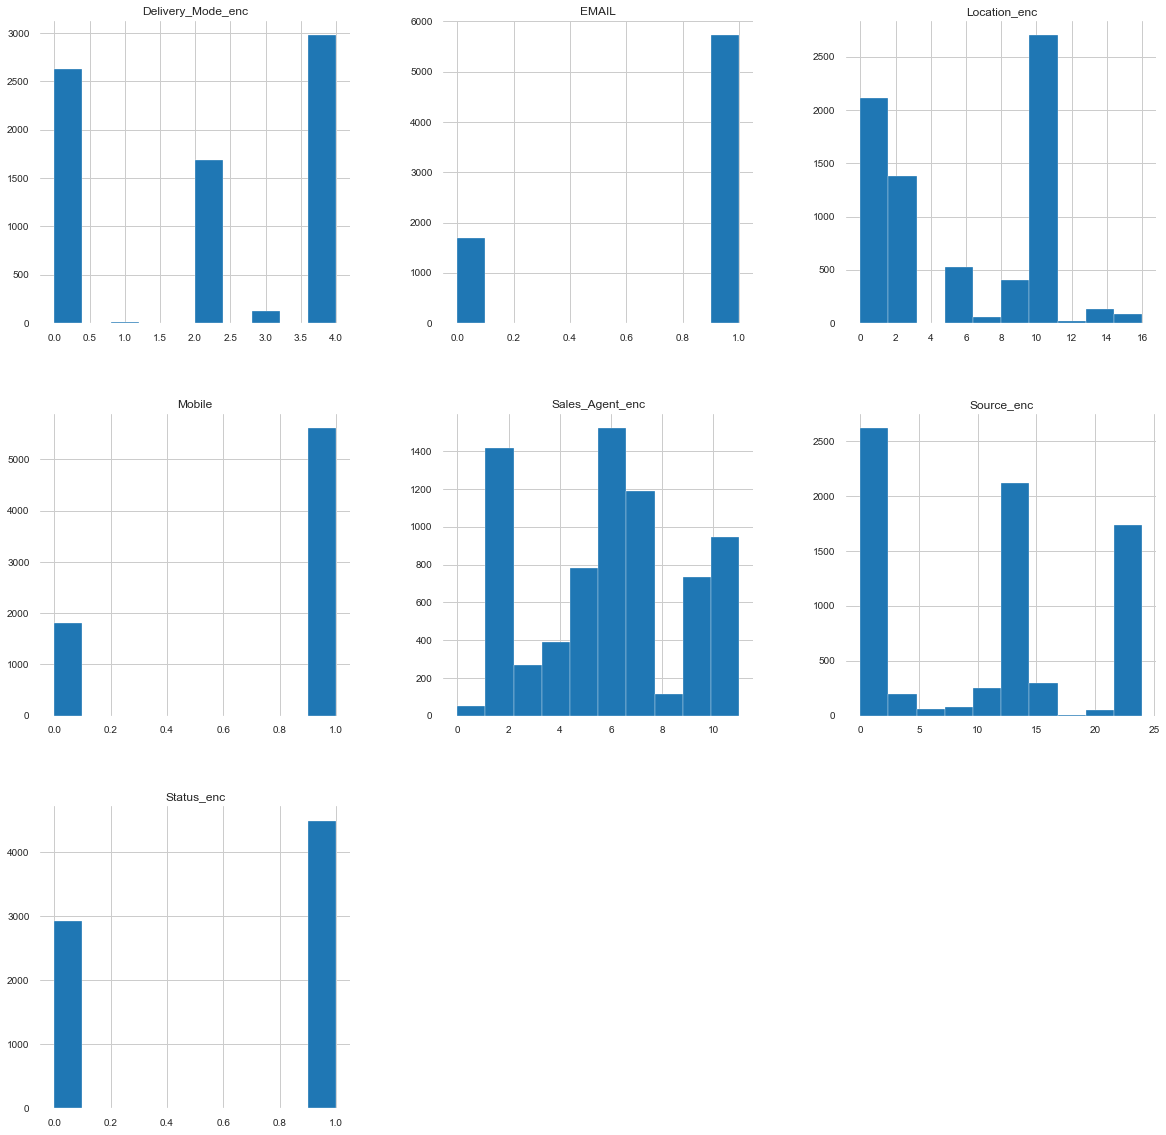

In [30]:
product_sales_data_enc[Catvar_list].hist(figsize=(20,20))

### Plotting the top-10 important features

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.

Feature importance scores play an important role in a predictive modeling project, including providing insight into the data, insight into the model, and the basis for dimensionality reduction and feature selection that can improve the efficiency and effectiveness of a predictive model on the problem.

In the below scenario, we have written a function to display the top-n important features. In our implementation, we are displaying the top-10 important features for our dataset using Random Forest classifier.

In [31]:
X_DT = product_sales_data_enc.drop(columns=['Status_enc'], axis=1)
y_DT = product_sales_data_enc.Status_enc

In [32]:
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.25, random_state=10)

In [33]:
XGBoostError = ""
LightGBMError = ""
ValueError = ""
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    #except (XGBoostError, LightGBMError, ValueError):
    except:
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    plt.rcParams.update({'figure.autolayout': True})
    #plt.rcParams["axes.edgecolor"] = "0.15"
    #plt.rcParams["axes.linewidth"]  = 1.25
    #plt.grid()

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(figsize=figsize)
    #plt.title("Feature Importances", fontsize = 15, fontweight="bold")
    plt.xlabel('Feature Importance Score', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    plt.savefig('Feature_Importance_before_scaling_ohe.png')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

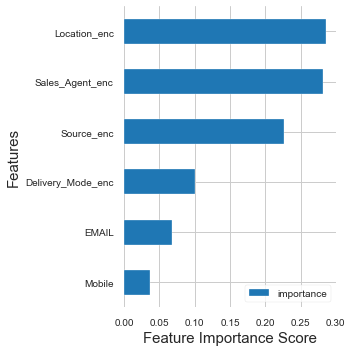

,importance
feature,
Mobile,0.036969
EMAIL,0.067198
Delivery_Mode_enc,0.100232
Source_enc,0.227221
Sales_Agent_enc,0.282344
Location_enc,0.286037


In [34]:
plot_feature_importances(RandomForestClassifier(random_state=rand_state), X_train_DT, y_train_DT, top_n=10, figsize=(5,5))

### Decision Tree Visualization

Decision trees are relatively easy to interpret as we can visualize the Decision Trees. In the below implementation, we will export hte decision tree visualization to a PNG file and also import the PNG file to the Jupyter Notebook so that the end user can have a quick view.

Since the output on the Jupyter Notebook seems too cramped, we will also attach the .png file along with the submission.

In [35]:
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train_DT,y_train_DT)
y_pred = clf.predict(X_test_DT)

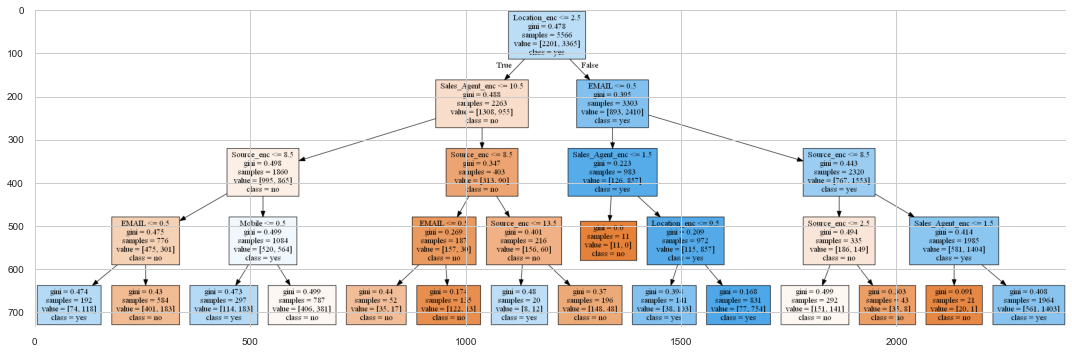

In [36]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train_DT.columns,  
                                class_names=['no', 'yes'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
graph.render("DT")

plt.figure(figsize=(15,15))

img = mpimg.imread('DT.png')
imgplot = plt.imshow(img)
plt.show()

## Scaling the data set

It is a step of Data Pre Processing which is applied to independent variables or features of data. It basically helps to normalise the data within a particular range. Sometimes, it also helps in speeding up the calculations in an algorithm. The Features have been scaled to a mean of 0 and variance of 1 to improve accuracy of the classification models.

*fit_transform* within MinMaxScaler() function fits to data, then transform it. Fits transformer to X and y with optional parameters fit_params and returns a transformed version of X.

In [37]:
scaler = MinMaxScaler()

In [38]:
product_sales_data_enc_scaled = pd.DataFrame(scaler.fit_transform(product_sales_data_enc), columns=product_sales_data_enc.columns)

## Correlation Matrix

Since we don't have any continous variables in our dataset, we will not check the correlation matrix.

## Balancing the dataset (Upsampling)

The attrition dataset is asymmetric and the model accuracy tends to be biased towards to the majority class. So, we synthetically balanced the dataset using the SMOTE method to upsample the minority class “Status = 0". Using this method, the number of observations in the minority class was increased to match the majority class. There was no change to the observations in the majority class. Balancing the dataset lets us use the Accuracy score along with Recall and Precision to compare model performance.

In [39]:
X = product_sales_data_enc_scaled.drop(columns=['Status_enc'], axis=1)
y = product_sales_data_enc_scaled.Status_enc

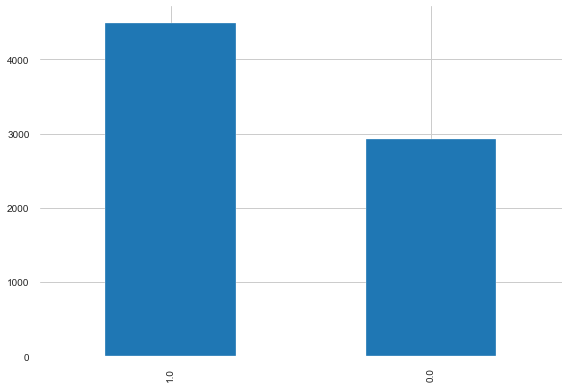

In [40]:
y.value_counts().plot(kind='bar')

In [41]:
smote = SMOTE()

In [42]:
X_smote, y_smote = smote.fit_sample(X.astype('float'), y)

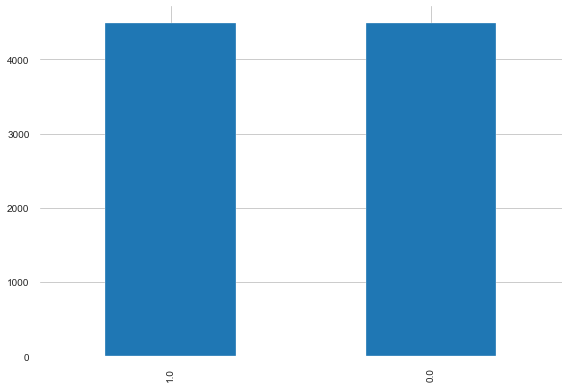

In [43]:
y_smote.value_counts().plot(kind='bar')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=rand_state)

In [45]:
y_train.value_counts()

1.0    3374
0.0    3362
Name: Status_enc, dtype: int64

In [46]:
y_test.value_counts()

0.0    1129
1.0    1117
Name: Status_enc, dtype: int64

### Set Baseline of the metrics

We start with executing selective models with default parameters on the complete data set. The confusion matrix along with the classification report and the accuracy of the model is printed below. The function confusion_mat displays the confusion matrix (using pd.crosstab) and classification report. It additionally extracts the FP and FN case counts passes the results back so that they can be compiled into a dataframe and used for comparison at a later stage.

In order to set the baseline metrics, we execute the below models with default parameters and full features:
- Logistic Regression
- Support Vector Machine
- Gaussian Naive-Bayes
- Bernoulli Naive-Bayes
- Decision Trees
- Random Forest
- XGBoost

#### K-fold Cross-Validation

This is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and test set. In cross-validation, the data set is split multiple times and the model is trained on each of these splits. For our analysis, we will be using k-fold cross-validation. 

KFold divides all the samples in groups of samples, called folds (if , this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using folds, and the fold left out is used for test.

Parameters for k-fold CV:
- n_splitsint - Number of folds
    - 5
- random_state - random_state is the seed used by the random number generator
    - 10

In [47]:
cv = KFold(n_splits=n_iterations, random_state=rand_state)

In [48]:
results_df = pd.DataFrame(columns=['Classifier', 'Features', 'Accuracy', 'Parameters', 'Recall', 
                                   'Precision', 'FPR', 'TPR', 'AUC', 'True_Positives', 
                                   'True_Negatives', 'False_Positives', 'False_Negatives'])
results_df

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives


In [49]:
def confusion_mat(y_test, y_pred):
    print('Confusion Matrix::\n')
    print(pd.crosstab(y_test, y_pred))
    print()
    print('Classification Report::')
    print(classification_report(y_test, y_pred))
    TN = pd.crosstab(y_test, y_pred).iloc[0, 0]
    FP = pd.crosstab(y_test, y_pred).iloc[0, 1]
    FN = pd.crosstab(y_test, y_pred).iloc[1, 0]
    TP = pd.crosstab(y_test, y_pred).iloc[1, 1]
    Cost = (FP*10)+(FN*500)
    Recall = recall_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    Accuracy = accuracy_score(y_test, y_pred)
    return(FP, FN, TP, TN, Accuracy, Recall, Precision)

In [50]:
clfsDict = {'Logistic Regression': LogisticRegression(solver = 'lbfgs', random_state=rand_state),
            'SVM (SVC)': SVC(gamma = 0.5, random_state=rand_state, probability=True), 
            'Gaussian Naive-Bayes': GaussianNB(),
            'Bernoulli Naive-Bayes': BernoulliNB(),
            'Decision Tree': DecisionTreeClassifier(random_state=rand_state),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=rand_state),
            'XGB': XGBClassifier(random_state=rand_state)}

In [51]:
for mdl, clf in clfsDict.items():
    start_1 = time()
    acc = cross_val_score(clf,X_train,y=y_train,cv=cv)
    clf.fit(X_train, y_train)
    y_pred_full_data = clf.predict(X_test)
    y_pred_proba_full_data = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_full_data)
    auc = roc_auc_score(y_test, y_pred_proba_full_data)
    (FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_full_data)
    results_df = results_df.append({'Classifier':mdl
                                    , 'Features':'Full'
                                    , 'Parameters': 'Default'
                                    , 'Accuracy': Accuracy
                                    , 'Recall': Recall
                                    , 'Precision': Precision
                                    , 'FPR': fpr
                                    , 'TPR': tpr
                                    , 'AUC': auc
                                    , 'True_Positives': TP
                                    , 'True_Negatives': TN
                                    , 'False_Positives': FP
                                    , 'False_Negatives': FN
                                   }
                                   , ignore_index=True
                                  )
    print()
    print('Process Time:: %0f' %(time()-start_1))
    print()

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         752  377
1.0         371  746

Classification Report::
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      1129
         1.0       0.66      0.67      0.67      1117

    accuracy                           0.67      2246
   macro avg       0.67      0.67      0.67      2246
weighted avg       0.67      0.67      0.67      2246


Process Time:: 0.137994

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         767  362
1.0         385  732

Classification Report::
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      1129
         1.0       0.67      0.66      0.66      1117

    accuracy                           0.67      2246
   macro avg       0.67      0.67      0.67      2246
weighted avg       0.67      0.67      0.67      2246


Process Time:: 21.949152

Confusion Matrix::

col_0       0.0

In [52]:
results_df

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives
0,Logistic Regression,Full,0.666963,Default,0.667860,0.664292,"[0.0, 0.005314437555358724, 0.0053144375553587...","[0.0, 0.0, 0.008057296329453895, 0.01432408236...",0.720446,746,752,377,371
1,SVM (SVC),Full,0.667409,Default,0.655327,0.669104,"[0.0, 0.0, 0.0, 0.0008857395925597874, 0.00088...","[0.0, 0.0008952551477170994, 0.001790510295434...",0.739141,732,767,362,385
2,Gaussian Naive-Bayes,Full,0.653161,Default,0.597135,0.669679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000885739592559787...","[0.0, 0.0017905102954341987, 0.008057296329453...",0.710860,667,800,329,450
3,Bernoulli Naive-Bayes,Full,0.583704,Default,0.326768,0.666058,"[0.0, 0.0070859167404783, 0.07617360496014172,...","[0.0, 0.05908683974932856, 0.26410026857654434...",0.637840,365,946,183,752
4,Decision Tree,Full,0.699466,Default,0.662489,0.712909,"[0.0, 0.09920283436669619, 0.09920283436669619...","[0.0, 0.26410026857654434, 0.2990152193375112,...",0.757301,740,831,298,377
5,Random Forest,Full,0.712378,Default,0.699194,0.715857,"[0.0, 0.011514614703277236, 0.0115146147032772...","[0.0, 0.08236347358997315, 0.08325872873769025...",0.789786,781,819,310,336
6,XGB,Full,0.723508,Default,0.746643,0.711604,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.0008952551477170994, 0.004476275738585...",0.808451,834,791,338,283


# Feature Reduction (RFECV)

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets. We have used Recursive Feature Elimination with Cross-Validation to limit the number of features input to the model.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

Parameters for RFECV:
- estimator - A supervised learning estimator with a fit method that provides information about feature importance.
    - RandomForestClassifier
- step - If greater than or equal to 1, then step corresponds to the number of features to remove at each iteration.
    - 4
- cv - Determines the cross-validation splitting strategy. Integer value specifies the number of folds.
    - 3
- scoring - A scoring method to determine which score to maximize
    - recall
    
##### Note: 
We dropped 4 features using RFECV. 

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6736 entries, 1962 to 1289
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mobile             6736 non-null   float64
 1   EMAIL              6736 non-null   float64
 2   Source_enc         6736 non-null   float64
 3   Sales_Agent_enc    6736 non-null   float64
 4   Location_enc       6736 non-null   float64
 5   Delivery_Mode_enc  6736 non-null   float64
dtypes: float64(6)
memory usage: 368.4 KB


In [54]:
clf = RandomForestClassifier(n_estimators=100, random_state=rand_state)
selector = RFECV(estimator=clf, step = 4, cv=3, scoring='accuracy')

In [55]:
#%%time

feature_fit = selector.fit(X_train, y_train)

print('The number of selected features with CV:: ', feature_fit.n_features_)
print('Selected Features:: ', X_train.columns[selector.support_])

The number of selected features with CV::  6
Selected Features::  Index(['Mobile', 'EMAIL', 'Source_enc', 'Sales_Agent_enc', 'Location_enc',
       'Delivery_Mode_enc'],
      dtype='object')


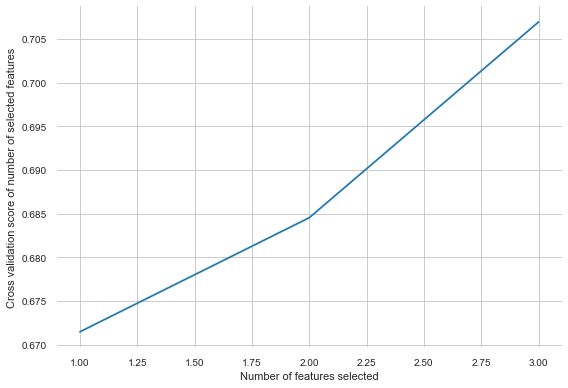

In [56]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [57]:
selector.grid_scores_

array([0.67146669, 0.68453104, 0.7069478 ])

In [58]:
X_train_reduced_features = X_train[X_train.columns[selector.support_]]
X_test_reduced_features = X_test[X_test.columns[selector.support_]]

In [59]:
X_train_reduced_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6736 entries, 1962 to 1289
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mobile             6736 non-null   float64
 1   EMAIL              6736 non-null   float64
 2   Source_enc         6736 non-null   float64
 3   Sales_Agent_enc    6736 non-null   float64
 4   Location_enc       6736 non-null   float64
 5   Delivery_Mode_enc  6736 non-null   float64
dtypes: float64(6)
memory usage: 368.4 KB


# Train the model on the reduced features

None of the features were dropped by RFECV. So, we proceed with full features (even though the data frame is called reduced features).

In this section all models use the default parameters to establish the baseline with reduced features before we tune the parameters using Randomized Search.

### Decision Tree

Decision trees can be applied to both regression and classification problems. While a regression tree is used to predict a quantitative response, a classification tree is used to predict a qualitative one. This algorithm constructs a tree from a training dataset in which each node is an attribute and branches are the corresponding values.

### Random Forest

Decision trees form the basis for Random Forests. Random Forest is an ensemble of decision trees trained via bagging method. The Random Forest algorithm introduces randomness when growing trees and rather than search for the best feature when splitting a node, it searches for the best feature among a random subset of features. It yeilds a better model by trading a higher bias for a lower variance. Random Forests are also very helpful to get a good understanding of feature importance when we need to perform feature selection.

### XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 

In [60]:
clfsDict = {#'Logistic Regression': LogisticRegression(solver = 'lbfgs', random_state=rand_state),
            #'SVM (SVC)': SVC(gamma = 0.5, random_state=rand_state, probability=True), 
            #'Gaussian Naive-Bayes': GaussianNB(),
            #'Bernoulli Naive-Bayes': BernoulliNB(),
            'Decision Tree': DecisionTreeClassifier(random_state=rand_state),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=rand_state),
            'XGB': XGBClassifier(random_state=rand_state)}

In [61]:
for mdl, clf in clfsDict.items():
    start_1 = time()
    acc = cross_val_score(clf,X_train_reduced_features,y=y_train,cv=cv)
    clf.fit(X_train_reduced_features, y_train)
    y_pred_full_data = clf.predict(X_test_reduced_features)
    y_pred_proba_full_data = clf.predict_proba(X_test_reduced_features)[:, 1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_full_data)
    auc = roc_auc_score(y_test, y_pred_proba_full_data)
    (FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_full_data)
    results_df = results_df.append({'Classifier':mdl
                                    , 'Features':'Reduced'
                                    , 'Parameters': 'Default'
                                    , 'Accuracy': Accuracy
                                    , 'Recall': Recall
                                    , 'Precision': Precision
                                    , 'FPR': fpr
                                    , 'TPR': tpr
                                    , 'AUC': auc
                                    , 'True_Positives': TP
                                    , 'True_Negatives': TN
                                    , 'False_Positives': FP
                                    , 'False_Negatives': FN
                                   }
                                   , ignore_index=True
                                  )
    print()
    print('Process Time:: %0f' %(time()-start_1))
    print()

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         831  298
1.0         377  740

Classification Report::
              precision    recall  f1-score   support

         0.0       0.69      0.74      0.71      1129
         1.0       0.71      0.66      0.69      1117

    accuracy                           0.70      2246
   macro avg       0.70      0.70      0.70      2246
weighted avg       0.70      0.70      0.70      2246


Process Time:: 0.153617

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         819  310
1.0         336  781

Classification Report::
              precision    recall  f1-score   support

         0.0       0.71      0.73      0.72      1129
         1.0       0.72      0.70      0.71      1117

    accuracy                           0.71      2246
   macro avg       0.71      0.71      0.71      2246
weighted avg       0.71      0.71      0.71      2246


Process Time:: 2.372282

Confusion Matrix::

col_0       0.0 

In [62]:
results_df.sort_values(by='AUC', ascending=True)

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives
3,Bernoulli Naive-Bayes,Full,0.583704,Default,0.326768,0.666058,"[0.0, 0.0070859167404783, 0.07617360496014172,...","[0.0, 0.05908683974932856, 0.26410026857654434...",0.637840,365,946,183,752
2,Gaussian Naive-Bayes,Full,0.653161,Default,0.597135,0.669679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000885739592559787...","[0.0, 0.0017905102954341987, 0.008057296329453...",0.710860,667,800,329,450
0,Logistic Regression,Full,0.666963,Default,0.667860,0.664292,"[0.0, 0.005314437555358724, 0.0053144375553587...","[0.0, 0.0, 0.008057296329453895, 0.01432408236...",0.720446,746,752,377,371
1,SVM (SVC),Full,0.667409,Default,0.655327,0.669104,"[0.0, 0.0, 0.0, 0.0008857395925597874, 0.00088...","[0.0, 0.0008952551477170994, 0.001790510295434...",0.739141,732,767,362,385
4,Decision Tree,Full,0.699466,Default,0.662489,0.712909,"[0.0, 0.09920283436669619, 0.09920283436669619...","[0.0, 0.26410026857654434, 0.2990152193375112,...",0.757301,740,831,298,377
7,Decision Tree,Reduced,0.699466,Default,0.662489,0.712909,"[0.0, 0.09920283436669619, 0.09920283436669619...","[0.0, 0.26410026857654434, 0.2990152193375112,...",0.757301,740,831,298,377
5,Random Forest,Full,0.712378,Default,0.699194,0.715857,"[0.0, 0.011514614703277236, 0.0115146147032772...","[0.0, 0.08236347358997315, 0.08325872873769025...",0.789786,781,819,310,336
8,Random Forest,Reduced,0.712378,Default,0.699194,0.715857,"[0.0, 0.011514614703277236, 0.0115146147032772...","[0.0, 0.08236347358997315, 0.08325872873769025...",0.789786,781,819,310,336
6,XGB,Full,0.723508,Default,0.746643,0.711604,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.0008952551477170994, 0.004476275738585...",0.808451,834,791,338,283
9,XGB,Reduced,0.723508,Default,0.746643,0.711604,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.0008952551477170994, 0.004476275738585...",0.808451,834,791,338,283


# GridSearchCV to choose best parameters

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

#### Options for RandomizedSearchCV
- estimator - A object of that type is instantiated for each grid point.
    - Assigned as per the algorithm we are tuning
- param_distributions - Dictionary with parameters names (string) as keys and distributions or lists of parameters to try.
    - Assigned as per the algorithm we are tuning
- scoring - A single string to evaluate the predictions on the test set.
    - ['precision' , 'recall' , 'accuracy']
- cv - Determines the cross-validation splitting strategy.
    - 5
- refit - Refit an estimator using the best found parameters on the whole dataset.
    - precision

In [63]:
scores = ['precision'
          , 'recall'
          , 'accuracy'
         ]

In [64]:
def report_perf(clf, n_top = 3, clf_name = "", verbose=True):
    if(verbose):
        for n in range(1, n_top+1):
            candidates = np.flatnonzero(clf.cv_results_['rank_test_recall'] == n)
            for candidate in candidates:
                print('Model with rank: {0}'.format(n))
                print('Mean validation score (Recall on Test): {0:.3f} (std: {1:.3f})'.format(
                    clf.cv_results_['mean_test_recall'][candidate], clf.cv_results_['std_test_recall'][candidate]))
                print('ParametersL {0}',format(clf.cv_results_['params'][candidate]))
    return{'Classifier': clf_name
           , 'Best_Parameters': str(clf.best_params_)
           , 'Best_Estimator': str(clf.best_estimator_)
#           , 'Accuracy_Mean':clf.cv_results_['mean_test_acc'][clf.best_index_]
#           , 'Accuracy_std':clf.cv_results_['std_test_acc'][clf.best_index_]
           , 'Precision_Mean':clf.cv_results_['mean_test_precision'][clf.best_index_]
           , 'Precision_std':clf.cv_results_['std_test_precision'][clf.best_index_]
           , 'Recall_Mean':clf.cv_results_['mean_test_recall'][clf.best_index_]
           , 'Recall_std':clf.cv_results_['std_test_recall'][clf.best_index_]
          }

### Decision Tree

We are tuning for the following parameters for *Decision Tree Classifier*:
- max_depth: The maximum depth of the tree.
    - [10, 20, 30, None]
- max_features: The number of features to consider when looking for the best split
    - ['auto', 'sqrt']
- criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
    - ['gini','entropy']
- min_samples_leaf: The minimum number of samples required to be at a leaf node.  
    - [1, 2, 4]
- min_samples_split: The minimum number of samples required to split an internal node
    - [2, 5, 10]
- random_state - If int, random_state is the seed used by the random number generator
    - 10

In [65]:
tuned_parameters_DT={'max_depth': [10, 20, 30, None]
                     , 'max_features': ['auto', 'sqrt']
                     , 'criterion':['gini','entropy']
                     , 'min_samples_leaf': [1, 2, 4]
                     , 'min_samples_split': [2, 5, 10]
                    }

clf_DT = DecisionTreeClassifier(random_state=rand_state)

In [66]:
#%%time

grid_search_DT = GridSearchCV(estimator=clf_DT
                                      , param_grid=tuned_parameters_DT
                                      , cv = cv
                                      , scoring = scores
                                      , refit ='precision'
                                      #, n_iter=10
                                     )

In [67]:
grid_search_DT.fit(X_train_reduced_features, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=10,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_

In [68]:
DT_report = report_perf(grid_search_DT, n_top = 3, clf_name='Decision_Tree')
DT_report

Model with rank: 1
Mean validation score (Recall on Test): 0.719 (std: 0.019)
ParametersL {0} {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}
Model with rank: 1
Mean validation score (Recall on Test): 0.719 (std: 0.019)
ParametersL {0} {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Model with rank: 3
Mean validation score (Recall on Test): 0.715 (std: 0.024)
ParametersL {0} {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10}
Model with rank: 3
Mean validation score (Recall on Test): 0.715 (std: 0.024)
ParametersL {0} {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}


{'Classifier': 'Decision_Tree',
 'Best_Parameters': "{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}",
 'Best_Estimator': "DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',\n                       max_depth=30, max_features='auto', max_leaf_nodes=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=2, min_samples_split=2,\n                       min_weight_fraction_leaf=0.0, presort='deprecated',\n                       random_state=10, splitter='best')",
 'Precision_Mean': 0.7255773967793633,
 'Precision_std': 0.02556165776838637,
 'Recall_Mean': 0.6387417628499483,
 'Recall_std': 0.023744117568031863}

### Random Forest

We are tuning the following parameters for Random Forest Classifier:
- n_estimators: The number of trees in the forest.
    - [100, 200]
- max_depth: The maximum depth of the tree.
    - [25, 50, None]
- criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
    - ['gini','entropy']
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
    - [1, 25, 50]
- max_features: The number of features to consider when looking for the best split.
    - [.2, .3, 'auto']
- min_samples_split: The minimum number of samples required to split an internal node.
    - [2, 4, 8, 10, 12]

In [69]:
tuned_parameters_RF={'n_estimators':[100, 200]
                     , 'max_depth':[25, 50, None]
                     , 'criterion':['gini','entropy']
                     , 'min_samples_leaf': [1, 25, 50]
                     , 'max_features':[.2, .3, 'auto']
                     , 'min_samples_split':[2, 4, 8, 10, 12]
                    }

clf_RF = RandomForestClassifier(random_state=rand_state)

In [70]:
#%%time

grid_search_RF = GridSearchCV(estimator=clf_RF
                                      #, param_distributions=tuned_parameters_RF
                                      , param_grid=tuned_parameters_RF
                                      , cv = cv
                                      , scoring = scores
                                      , refit = 'precision'
                                      #, n_iter=10
                                     )

grid_search_RF.fit(X_train_reduced_features, y_train)

RF_report = report_perf(grid_search_RF, n_top = 3, clf_name='Random_Forest')

Model with rank: 1
Mean validation score (Recall on Test): 0.711 (std: 0.025)
ParametersL {0} {'criterion': 'gini', 'max_depth': 50, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 200}
Model with rank: 1
Mean validation score (Recall on Test): 0.711 (std: 0.025)
ParametersL {0} {'criterion': 'gini', 'max_depth': 50, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 200}
Model with rank: 1
Mean validation score (Recall on Test): 0.711 (std: 0.025)
ParametersL {0} {'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 200}
Model with rank: 1
Mean validation score (Recall on Test): 0.711 (std: 0.025)
ParametersL {0} {'criterion': 'gini', 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 200}


In [71]:
RF_report

{'Classifier': 'Random_Forest',
 'Best_Parameters': "{'criterion': 'gini', 'max_depth': 50, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 200}",
 'Best_Estimator': "RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,\n                       criterion='gini', max_depth=50, max_features=0.2,\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_split=12,\n                       min_weight_fraction_leaf=0.0, n_estimators=200,\n                       n_jobs=None, oob_score=False, random_state=10, verbose=0,\n                       warm_start=False)",
 'Precision_Mean': 0.7220350656059662,
 'Precision_std': 0.03119799853962202,
 'Recall_Mean': 0.7111080718387854,
 'Recall_std': 0.02513976389702457}

### XGBoost

We are tuning the following parameters for XGBoost:
- n_estimators: Number of gradient boosted trees. Equivalent to number of boosting rounds.
    - [100, 150, 1000]
- learning_rate: Boosting learning rate (xgb’s “eta”)
    - [0.01, 0.6, None]
- subsample: Subsample ratio of the training instances.
    - [0.3, 0.9, None]
- max_depth: Maximum depth of a tree.
    - [3, 4, 5, 6, 7, 8, 9, None]
- colsample_bytree: The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    - [0.5, 0.9, None]
- min_child_weight: Minimum sum of instance weight (hessian) needed in a child.
    - [1, 2, 3, 4, None]

In [72]:
tuned_parameters_XGB={'n_estimators': [100, 150, 1000]
                      , 'learning_rate': [0.01, 0.6, None]
                      , 'subsample': [0.3, 0.9, None]
                      , 'max_depth': [3, 4, 5, 6, 7, 8, 9, None]
                      , 'colsample_bytree': [0.5, 0.9, None]
                      , 'min_child_weight': [1, 2, 3, 4, None]
                     }

clf_XGB = XGBClassifier(random_state=rand_state)

In [73]:
#%%time

grid_search_XGB = GridSearchCV(estimator=clf_XGB
                                      #, param_distributions=tuned_parameters_XGB
                                      , param_grid=tuned_parameters_RF
                                      , cv = cv
                                      , scoring = scores
                                      , refit ='precision'
                                      #, n_iter=10
                                     )

In [74]:
grid_search_XGB.fit(X_train_reduced_features, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None...
                                     verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [25, 50, None],
                         'max_features': [0.2, 0.3, 'auto'],
                         'min_samples_leaf': [1, 25, 50],
               

In [75]:
XGB_report = report_perf(grid_search_XGB, n_top = 3, clf_name='XGBoost')

Model with rank: 1
Mean validation score (Recall on Test): 0.733 (std: 0.012)
ParametersL {0} {'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model with rank: 1
Mean validation score (Recall on Test): 0.733 (std: 0.012)
ParametersL {0} {'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Model with rank: 1
Mean validation score (Recall on Test): 0.733 (std: 0.012)
ParametersL {0} {'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
Model with rank: 1
Mean validation score (Recall on Test): 0.733 (std: 0.012)
ParametersL {0} {'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Model with rank: 1
Mean validation score (Recall on Test): 0.733 (std: 0.012)
ParametersL {0} {'criteri

### Append random_state to the best parameters

We assign the best parameters from each of the Random Search to a variable and then add the random state parameter to it. These variables will be passed on to train the models with reduced features and best parameters.

In [76]:
DT_best_params = grid_search_DT.best_params_
DT_best_params['random_state'] = rand_state

RF_best_params = grid_search_RF.best_params_
RF_best_params['random_state'] = rand_state

XGB_best_params = grid_search_XGB.best_params_
XGB_best_params['random_state'] = rand_state

### Train the model with the best parameters.

In [77]:
clfsDict = {#'Logistic Regression': LogisticRegression(solver = 'lbfgs', random_state=rand_state),
            #'SVM (SVC)': SVC(gamma = 0.5, random_state=rand_state, probability=True), 
            #'Gaussian Naive-Bayes': GaussianNB(),
            #'Bernoulli Naive-Bayes': BernoulliNB(),
            'Decision Tree': DecisionTreeClassifier(**DT_best_params),
            'Random Forest': RandomForestClassifier(**RF_best_params),
            'XGB': XGBClassifier(**XGB_best_params)}

In [78]:
for mdl, clf in clfsDict.items():
    start_1 = time()
    acc = cross_val_score(clf,X_train_reduced_features,y=y_train,cv=cv)
    clf.fit(X_train_reduced_features, y_train)
    y_pred_full_data = clf.predict(X_test_reduced_features)
    y_pred_proba_full_data = clf.predict_proba(X_test_reduced_features)[:, 1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_full_data)
    auc = roc_auc_score(y_test, y_pred_proba_full_data)
    (FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_full_data)
    results_df = results_df.append({'Classifier':mdl
                                    , 'Features':'Reduced'
                                    , 'Parameters': 'Best'
                                    , 'Accuracy': Accuracy
                                    , 'Recall': Recall
                                    , 'Precision': Precision
                                    , 'FPR': fpr
                                    , 'TPR': tpr
                                    , 'AUC': auc
                                    , 'True_Positives': TP
                                    , 'True_Negatives': TN
                                    , 'False_Positives': FP
                                    , 'False_Negatives': FN
                                   }
                                   , ignore_index=True
                                  )
    print()
    print('Process Time:: %0f' %(time()-start_1))
    print()

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         839  290
1.0         412  705

Classification Report::
              precision    recall  f1-score   support

         0.0       0.67      0.74      0.71      1129
         1.0       0.71      0.63      0.67      1117

    accuracy                           0.69      2246
   macro avg       0.69      0.69      0.69      2246
weighted avg       0.69      0.69      0.69      2246


Process Time:: 0.288841

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         809  320
1.0         328  789

Classification Report::
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71      1129
         1.0       0.71      0.71      0.71      1117

    accuracy                           0.71      2246
   macro avg       0.71      0.71      0.71      2246
weighted avg       0.71      0.71      0.71      2246


Process Time:: 9.740103

Confusion Matrix::

col_0       0.0 

In [79]:
results_df.sort_values(by='AUC', ascending=True)

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives
3,Bernoulli Naive-Bayes,Full,0.583704,Default,0.326768,0.666058,"[0.0, 0.0070859167404783, 0.07617360496014172,...","[0.0, 0.05908683974932856, 0.26410026857654434...",0.637840,365,946,183,752
2,Gaussian Naive-Bayes,Full,0.653161,Default,0.597135,0.669679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000885739592559787...","[0.0, 0.0017905102954341987, 0.008057296329453...",0.710860,667,800,329,450
0,Logistic Regression,Full,0.666963,Default,0.667860,0.664292,"[0.0, 0.005314437555358724, 0.0053144375553587...","[0.0, 0.0, 0.008057296329453895, 0.01432408236...",0.720446,746,752,377,371
1,SVM (SVC),Full,0.667409,Default,0.655327,0.669104,"[0.0, 0.0, 0.0, 0.0008857395925597874, 0.00088...","[0.0, 0.0008952551477170994, 0.001790510295434...",0.739141,732,767,362,385
4,Decision Tree,Full,0.699466,Default,0.662489,0.712909,"[0.0, 0.09920283436669619, 0.09920283436669619...","[0.0, 0.26410026857654434, 0.2990152193375112,...",0.757301,740,831,298,377
7,Decision Tree,Reduced,0.699466,Default,0.662489,0.712909,"[0.0, 0.09920283436669619, 0.09920283436669619...","[0.0, 0.26410026857654434, 0.2990152193375112,...",0.757301,740,831,298,377
10,Decision Tree,Reduced,0.687444,Best,0.631155,0.708543,"[0.0, 0.046944198405668734, 0.0487156775907883...","[0.0, 0.1423455684870188, 0.18800358102059087,...",0.759166,705,839,290,412
5,Random Forest,Full,0.712378,Default,0.699194,0.715857,"[0.0, 0.011514614703277236, 0.0115146147032772...","[0.0, 0.08236347358997315, 0.08325872873769025...",0.789786,781,819,310,336
8,Random Forest,Reduced,0.712378,Default,0.699194,0.715857,"[0.0, 0.011514614703277236, 0.0115146147032772...","[0.0, 0.08236347358997315, 0.08325872873769025...",0.789786,781,819,310,336
11,Random Forest,Reduced,0.711487,Best,0.706356,0.711452,"[0.0, 0.0008857395925597874, 0.000885739592559...","[0.0, 0.03222918531781558, 0.03491495076096687...",0.793998,789,809,320,328


## Ensemble Models

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Stacking, also called Super Learning or Stacked Regression, is a class of algorithms that involves training a second-level "metalearner" to find the optimal combination of the base learners. Unlike bagging and boosting, the goal in stacking is to ensemble strong, diverse sets of learners together.

### Ensemble Model 1

The first ensemble technique uses the vecstack package for stacking. It is compatible with the scikit-learn API to automate OOF computation, prediction and bagging using multiple models and stages.

Below, we use the Best Decision Tree and Random Forest classifiers in Stage 1. The Stage 1 output is passed on to Stage 2 which uses the XGBoost classifier with the best parameters. Finally, Logistic Regression is used as the Meta Classifier to predict the outcome and compare against the test dataset. 

In [80]:
clf_DT_best = DecisionTreeClassifier(**DT_best_params)
clf_RF_best = RandomForestClassifier(**RF_best_params)
clf_XGB_Best = XGBClassifier(**XGB_best_params)

In [81]:
models_1 = [clf_DT_best
            , clf_RF_best]

# Get out-of-fold predictions from 1-level models
S_1_train, S_1_test = stacking(models_1
                               , X_train_reduced_features
                               , y_train
                               , X_test_reduced_features
                               , regression = True
                               , metric=precision_score
                               , verbose = 2)

task:         [regression]
metric:       [precision_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.70806658]
    fold  1:  [0.67830424]
    fold  2:  [0.71929825]
    fold  3:  [0.73368842]
    ----
    MEAN:     [0.70983937] + [0.02034610]
    FULL:     [0.70926829]

model  1:     [RandomForestClassifier]
    fold  0:  [0.70446735]
    fold  1:  [0.68389423]
    fold  2:  [0.72276029]
    fold  3:  [0.73557692]
    ----
    MEAN:     [0.71167470] + [0.01948016]
    FULL:     [0.71156705]



In [82]:
# Initialize 2-level models
models_2 = [clf_XGB_Best]

# Get out-of-fold predictions from 2-level models
S_2_train, S_2_test = stacking(models_2
                               , S_1_train
                               , y_train
                               , S_1_test
                               , regression = True
                               , metric=precision_score
                               , verbose = 2)

task:         [regression]
metric:       [precision_score]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [XGBClassifier]
    fold  0:  [0.70446735]
    fold  1:  [0.68389423]
    fold  2:  [0.72276029]
    fold  3:  [0.73557692]
    ----
    MEAN:     [0.71167470] + [0.01948016]
    FULL:     [0.71156705]



In [83]:
# Initialize 3-level model
model = LogisticRegression(random_state=rand_state)
# Fit
model.fit(S_2_train, y_train)
# Get final prediction
y_pred_ensemble = model.predict(S_2_test)

In [84]:
model.predict_proba(S_2_test)

array([[0.70863062, 0.29136938],
       [0.28896515, 0.71103485],
       [0.70863062, 0.29136938],
       ...,
       [0.70863062, 0.29136938],
       [0.28896515, 0.71103485],
       [0.28896515, 0.71103485]])

In [85]:
y_pred_proba = model.predict_proba(S_2_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ensemble)
results_df = results_df.append({'Classifier':'Vecstack'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         768  361
1.0         296  821

Classification Report::
              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      1129
         1.0       0.69      0.74      0.71      1117

    accuracy                           0.71      2246
   macro avg       0.71      0.71      0.71      2246
weighted avg       0.71      0.71      0.71      2246



### Ensemble Model 2

The second ensemble technique uses the StackingCVClassifier from mlxtend package. 

In this model, we pass all our 3 best models (Decision Tree, Random Forest and XGBoost) together in 1 stage. Similar to the previous ensemble model, we use Logistic Regression as our Meta-Classifier.

In [86]:
sclf = StackingCVClassifier(classifiers=[clf_DT_best, clf_RF_best, clf_XGB_Best]
                            , use_probas=True
                            , random_state= rand_state
                            , meta_classifier=LogisticRegression(random_state=rand_state))

In [87]:
label = ['Decision Tree', 'Random Forest', 'XGBoost', 'Stacking Classifier']
clf_list = [clf_DT_best, clf_RF_best, clf_XGB_Best, sclf]
    
sclf.fit(X_train_reduced_features, y_train)
y_pred_sclf = sclf.predict(X_test_reduced_features)

In [88]:
y_pred_proba = sclf.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_sclf)
results_df = results_df.append({'Classifier':'StackingCV'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         806  323
1.0         303  814

Classification Report::
              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72      1129
         1.0       0.72      0.73      0.72      1117

    accuracy                           0.72      2246
   macro avg       0.72      0.72      0.72      2246
weighted avg       0.72      0.72      0.72      2246



### Ensemble Model 3

Stack of estimators with a final classifier. Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In this step, we use multi-layer classsifier technique. In multi-layer classifier, we assign the final estimator to a stacking classifier.

In [89]:
final_layer = StackingClassifier(estimators=[('rf', clf_RF_best)
                                            , ('xgb', clf_XGB_Best)]
                                , final_estimator=LogisticRegression(random_state=rand_state)
                               )

multi_layer_regressor = StackingClassifier(estimators=[('dt', clf_DT_best)]
                                          , final_estimator=final_layer
                                         )

multi_layer_regressor.fit(X_train_reduced_features, y_train)

y_pred_multi = multi_layer_regressor.predict(X_test_reduced_features)

In [90]:
y_pred_proba = multi_layer_regressor.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_multi)
results_df = results_df.append({'Classifier':'Stacking (Logistic)'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         802  327
1.0         378  739

Classification Report::
              precision    recall  f1-score   support

         0.0       0.68      0.71      0.69      1129
         1.0       0.69      0.66      0.68      1117

    accuracy                           0.69      2246
   macro avg       0.69      0.69      0.69      2246
weighted avg       0.69      0.69      0.69      2246



### Ensemble Model 4

Ensemble Model 4 is similar to Ensemble Model 3. However, in this step, we use a single stacking layer with Decision Tree, Random Forest and XGBoost with the best parameters passed as ensemble estimators. SGD is chosen as the final estimator or meta-classifier as discussed in Ensemble Model 1 and 2.

In [91]:
ensemble_estimators = [('rf', clf_RF_best)
                       , ('xgb', clf_XGB_Best)
                       , ('dt', clf_DT_best)
#                       , ('logistic', LogisticRegression(random_state=rand_state))
                      ]

clf_ensemble = StackingClassifier(estimators=ensemble_estimators
                                  , final_estimator=CalibratedClassifierCV(SGDClassifier(random_state=rand_state))
#                                  , final_estimator=SVC(gamma = 0.5, random_state=rand_state)
                                 )

clf_ensemble.fit(X_train_reduced_features, y_train)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=50,
                                                       max_features=0.2,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=12,
                                         

In [92]:
y_pred_ens = clf_ensemble.predict(X_test_reduced_features)

In [93]:
y_pred_proba = clf_ensemble.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ens)
results_df = results_df.append({'Classifier':'Stacking (SGD)'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         798  331
1.0         289  828

Classification Report::
              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72      1129
         1.0       0.71      0.74      0.73      1117

    accuracy                           0.72      2246
   macro avg       0.72      0.72      0.72      2246
weighted avg       0.72      0.72      0.72      2246



### Ensemble Model 5

Ensemble model 5 is the same as Ensemble Model 4. The only difference is that we are using SMV (SVC) as the final estimator here instead of SGD.

In [94]:
ensemble_estimators_5 = [('rf', clf_RF_best)
                       , ('xgb', clf_XGB_Best)
                       , ('dt', clf_DT_best)
#                       , ('logistic', LogisticRegression(random_state=rand_state))
                      ]

clf_ensemble_5 = StackingClassifier(estimators=ensemble_estimators_5
#                                   , final_estimator=SGDClassifier(random_state=rand_state)
                                    , final_estimator=CalibratedClassifierCV(SVC(gamma = 0.5, random_state=rand_state))
                                 )

clf_ensemble_5.fit(X_train_reduced_features, y_train)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=50,
                                                       max_features=0.2,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=12,
                                         

In [95]:
y_pred_ens_5 = clf_ensemble_5.predict(X_test_reduced_features)

In [96]:
y_pred_proba = clf_ensemble_5.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ens_5)
results_df = results_df.append({'Classifier':'Stacking (SVC)'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         804  325
1.0         285  832

Classification Report::
              precision    recall  f1-score   support

         0.0       0.74      0.71      0.72      1129
         1.0       0.72      0.74      0.73      1117

    accuracy                           0.73      2246
   macro avg       0.73      0.73      0.73      2246
weighted avg       0.73      0.73      0.73      2246



### Ensemble Model 6

The final ensemble technique uses the VotingClassifier from sklearn package. 

In this model, we pass all our 3 best models (Decision Tree, Random Forest and XGBoost) together and use the soft voting to determine our output. Soft voting takes into account how certain each voter is, rather than just a binary input from the voter.

In [97]:
clf_ensemble_6 = VotingClassifier(estimators=[('rf', clf_RF_best)
                                              , ('xgb', clf_XGB_Best)
                                              , ('dt', clf_DT_best)]
                                  , voting='soft')

clf_ensemble_6.fit(X_train_reduced_features, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=50,
                                                     max_features=0.2,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=12,
                                                     min_weight_fraction_leaf=0.0,
            

In [98]:
y_pred_ens_6 = clf_ensemble_6.predict(X_test_reduced_features)

In [99]:
y_pred_proba = clf_ensemble_6.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ens_6)
results_df = results_df.append({'Classifier':'Voting'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0       0.0  1.0
Status_enc          
0.0         821  308
1.0         319  798

Classification Report::
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72      1129
         1.0       0.72      0.71      0.72      1117

    accuracy                           0.72      2246
   macro avg       0.72      0.72      0.72      2246
weighted avg       0.72      0.72      0.72      2246



## Comparison and interpretation of the results

Now that we have executed all the models, we begin to look at the results. A quick review shows us that there may be some problem with at least one of the metrics becaues the Accuracy and Recall Scores are always the same. To resolve this issue, let's calculate the Accuracy, Recall and Precision scores manually based on the outputs that we have gathered from our model execution.

We have followed the below steps in order to interpret the models:
- Sort the result set by Accuracy and AUC scores and retain only 1 record per Classifier based on the best scores.
- Plot the ROC-AUC Curves
- Scatter-plot the Recall vs. the Precision scores

In [100]:
results_df

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives
0,Logistic Regression,Full,0.666963,Default,0.667860,0.664292,"[0.0, 0.005314437555358724, 0.0053144375553587...","[0.0, 0.0, 0.008057296329453895, 0.01432408236...",0.720446,746,752,377,371
1,SVM (SVC),Full,0.667409,Default,0.655327,0.669104,"[0.0, 0.0, 0.0, 0.0008857395925597874, 0.00088...","[0.0, 0.0008952551477170994, 0.001790510295434...",0.739141,732,767,362,385
2,Gaussian Naive-Bayes,Full,0.653161,Default,0.597135,0.669679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000885739592559787...","[0.0, 0.0017905102954341987, 0.008057296329453...",0.710860,667,800,329,450
3,Bernoulli Naive-Bayes,Full,0.583704,Default,0.326768,0.666058,"[0.0, 0.0070859167404783, 0.07617360496014172,...","[0.0, 0.05908683974932856, 0.26410026857654434...",0.637840,365,946,183,752
4,Decision Tree,Full,0.699466,Default,0.662489,0.712909,"[0.0, 0.09920283436669619, 0.09920283436669619...","[0.0, 0.26410026857654434, 0.2990152193375112,...",0.757301,740,831,298,377
5,Random Forest,Full,0.712378,Default,0.699194,0.715857,"[0.0, 0.011514614703277236, 0.0115146147032772...","[0.0, 0.08236347358997315, 0.08325872873769025...",0.789786,781,819,310,336
6,XGB,Full,0.723508,Default,0.746643,0.711604,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.0008952551477170994, 0.004476275738585...",0.808451,834,791,338,283
7,Decision Tree,Reduced,0.699466,Default,0.662489,0.712909,"[0.0, 0.09920283436669619, 0.09920283436669619...","[0.0, 0.26410026857654434, 0.2990152193375112,...",0.757301,740,831,298,377
8,Random Forest,Reduced,0.712378,Default,0.699194,0.715857,"[0.0, 0.011514614703277236, 0.0115146147032772...","[0.0, 0.08236347358997315, 0.08325872873769025...",0.789786,781,819,310,336
9,XGB,Reduced,0.723508,Default,0.746643,0.711604,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.0008952551477170994, 0.004476275738585...",0.808451,834,791,338,283


#### Retain 1 Classifier instance based on performance
- Sort by Accuracy and AUC Score 
- Retain one row per classifier

In [101]:
results_df_temp = results_df.sort_values(by=['Classifier', 'AUC']).groupby('Classifier').last()

In [102]:
results_df.sort_values(by=['Classifier', 'AUC']).groupby('Classifier').last()

,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives
Classifier,,,,,,,,,,,,
Bernoulli Naive-Bayes,Full,0.583704,Default,0.326768,0.666058,"[0.0, 0.0070859167404783, 0.07617360496014172,...","[0.0, 0.05908683974932856, 0.26410026857654434...",0.637840,365,946,183,752
Decision Tree,Reduced,0.687444,Best,0.631155,0.708543,"[0.0, 0.046944198405668734, 0.0487156775907883...","[0.0, 0.1423455684870188, 0.18800358102059087,...",0.759166,705,839,290,412
Gaussian Naive-Bayes,Full,0.653161,Default,0.597135,0.669679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000885739592559787...","[0.0, 0.0017905102954341987, 0.008057296329453...",0.710860,667,800,329,450
Logistic Regression,Full,0.666963,Default,0.667860,0.664292,"[0.0, 0.005314437555358724, 0.0053144375553587...","[0.0, 0.0, 0.008057296329453895, 0.01432408236...",0.720446,746,752,377,371
Random Forest,Reduced,0.711487,Best,0.706356,0.711452,"[0.0, 0.0008857395925597874, 0.000885739592559...","[0.0, 0.03222918531781558, 0.03491495076096687...",0.793998,789,809,320,328
SVM (SVC),Full,0.667409,Default,0.655327,0.669104,"[0.0, 0.0, 0.0, 0.0008857395925597874, 0.00088...","[0.0, 0.0008952551477170994, 0.001790510295434...",0.739141,732,767,362,385
Stacking (Logistic),Reduced,0.686109,Best,0.661594,0.693246,"[0.0, 0.001771479185119575, 0.0053144375553587...","[0.0, 0.06535362578334826, 0.08325872873769025...",0.759578,739,802,327,378
Stacking (SGD),Reduced,0.723954,Best,0.741271,0.714409,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.004476275738585497, 0.0080572963294538...",0.810211,828,798,331,289
Stacking (SVC),Reduced,0.728406,Best,0.744852,0.719101,"[0.0, 0.0, 0.0, 0.0, 0.0008857395925597874, 0....","[0.0, 0.0008952551477170994, 0.002685765443151...",0.801898,832,804,325,285


##### Plot the ROC-AUC curve

The Receiver Operating Characteristic (ROC) curve is common model evaluation tool for binary classifiers. It is similar to the concept of plotting the precision vs. recall. However, the ROC curve plots the true positive rate (TPR) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly labeled as positive. The model performance is determined by the area under the curve. Better models have more area under the curve. ROC-AUC is one of the most important evaluation metrics for checking any classification model’s performance. Higher the AUC, better the model is at distinguishing between a successful marketing call and a failed one.

In [103]:
roc_plot_df = results_df_temp[['Features', 'Parameters', 
                               'AUC', 'FPR', 'TPR']].sort_values(by = 'AUC', 
                                                                         ascending=False)

In [104]:
roc_plot_df['Clf'] = roc_plot_df[['Features', 'Parameters']].apply(lambda x: '_'.join(x), axis=1)

In [105]:
roc_plot_df

,Features,Parameters,AUC,FPR,TPR,Clf
Classifier,,,,,,
Stacking (SGD),Reduced,Best,0.810211,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.004476275738585497, 0.0080572963294538...",Reduced_Best
StackingCV,Reduced,Best,0.808892,"[0.0, 0.0, 0.0, 0.0008857395925597874, 0.00088...","[0.0, 0.004476275738585497, 0.0161145926589077...",Reduced_Best
XGB,Reduced,Best,0.808451,"[0.0, 0.0, 0.0008857395925597874, 0.0008857395...","[0.0, 0.0008952551477170994, 0.004476275738585...",Reduced_Best
Voting,Reduced,Best,0.803009,"[0.0, 0.0008857395925597874, 0.000885739592559...","[0.0, 0.0035810205908683975, 0.009847806624888...",Reduced_Best
Stacking (SVC),Reduced,Best,0.801898,"[0.0, 0.0, 0.0, 0.0, 0.0008857395925597874, 0....","[0.0, 0.0008952551477170994, 0.002685765443151...",Reduced_Best
Random Forest,Reduced,Best,0.793998,"[0.0, 0.0008857395925597874, 0.000885739592559...","[0.0, 0.03222918531781558, 0.03491495076096687...",Reduced_Best
Stacking (Logistic),Reduced,Best,0.759578,"[0.0, 0.001771479185119575, 0.0053144375553587...","[0.0, 0.06535362578334826, 0.08325872873769025...",Reduced_Best
Decision Tree,Reduced,Best,0.759166,"[0.0, 0.046944198405668734, 0.0487156775907883...","[0.0, 0.1423455684870188, 0.18800358102059087,...",Reduced_Best
SVM (SVC),Full,Default,0.739141,"[0.0, 0.0, 0.0, 0.0008857395925597874, 0.00088...","[0.0, 0.0008952551477170994, 0.001790510295434...",Full_Default


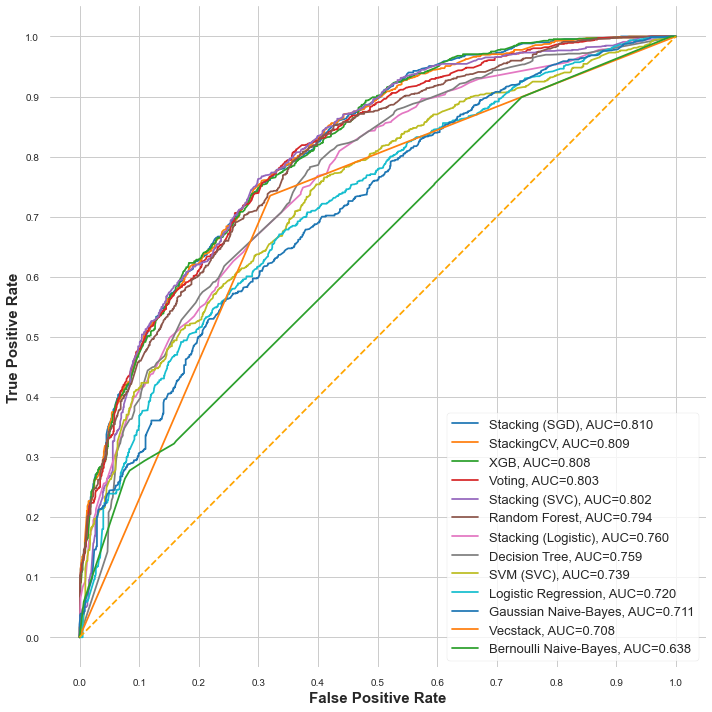

In [106]:
fig = plt.figure(figsize=(10,10))

for i in roc_plot_df.index:
    plt.plot(roc_plot_df.loc[i]['FPR'], 
             roc_plot_df.loc[i]['TPR'], 
             label="{}, AUC={:.3f}".format(i, roc_plot_df.loc[i]['AUC']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.rcParams.update({'figure.autolayout': True})

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15, fontweight="bold")

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15, fontweight="bold")

#plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig('ROC_Curve_Analysis.png')

plt.show()

To assess the accuracies of the model, the ROC curves of all the models were plotted. Since we executed the model with multiple parameters and features, we sorted the models by AUC scores and selected one output per model based on the AUC score. While the Stacking (SGD) Ensemble model, StackingCV, and XGBoost models have the AUC value seperated by less than 0.002 between them, Voting Classifier and Stacking (SVC) complete the top-5. 

Generally, models with 0.9 or better ROC-AUC score are generally said to be able to provide outstanding classification of the target variable. However, since there were limited features in our data set and we did not have any continous features, we could not achieve a high AUC score. Our top-5 models had AUC score greater than 0.8.

##### Plot Precision vs. Recall

In every machine learning problem, it is a struggle to determine whether we would like to reduce the false positives or false negatives. In this particular case study, we would like to reduce false positives so that we can make the best of our high potential, and by extension increase the precision score. 

In [107]:
results_df_temp.reset_index(inplace=True)
df_results_temp_scatter = results_df_temp[(results_df_temp['Recall']>0.7) & (results_df_temp['Precision']>0.6)]
df_results_temp_scatter = df_results_temp_scatter.loc[:, ['Classifier','Precision', 'Recall']].sort_values(by='Precision')

In [108]:
df_results_temp_scatter

,Classifier,Precision,Recall
10,Vecstack,0.694585,0.735004
4,Random Forest,0.711452,0.706356
12,XGB,0.711604,0.746643
7,Stacking (SGD),0.714409,0.741271
9,StackingCV,0.715919,0.728738
8,Stacking (SVC),0.719101,0.744852
11,Voting,0.721519,0.714414


In [109]:
precision = df_results_temp_scatter['Precision'].to_list
recall = df_results_temp_scatter['Recall'].to_list
classifier = df_results_temp_scatter['Classifier'].to_list

<Figure size 576x396 with 0 Axes>

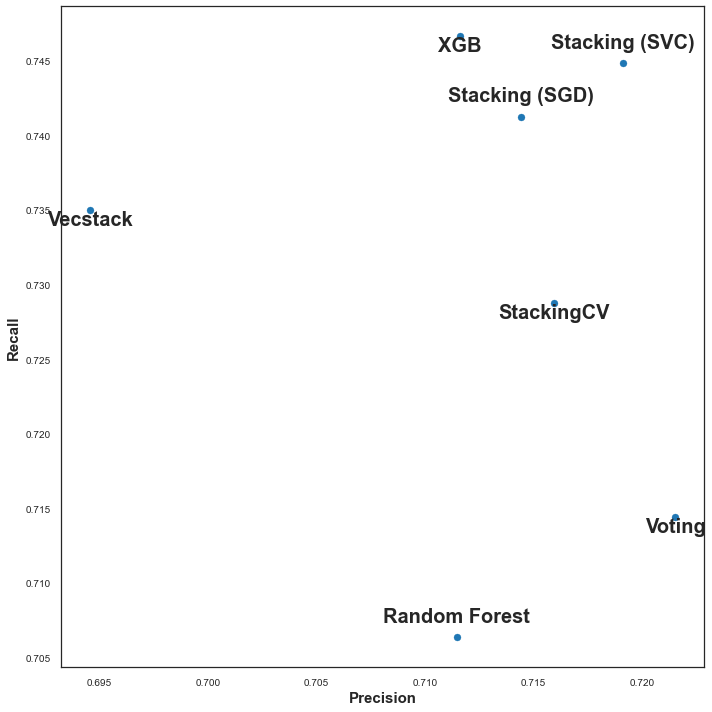

In [110]:
plt.clf()
plt.rcParams.update({'figure.autolayout': True})
plt.figure(figsize=(10,10))
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.scatter(df_results_temp_scatter.Precision, df_results_temp_scatter.Recall)
plt.grid()
temp = -1
temp_1 = -1
for x,y,z in zip(df_results_temp_scatter.Precision, df_results_temp_scatter.Recall, df_results_temp_scatter.Classifier):
    temp_1 = temp_1*temp

    plt.annotate(z, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15*temp_1), # distance from text to points (x,y)
                 fontweight="bold", 
                 fontsize = 20, 
                 ha='center') # horizontal alignment can be left, right or center

#plt.title("Precision vs. Recall", fontsize = 15, fontweight="bold")
plt.xlabel("Precision", fontsize=15, fontweight="bold")
plt.ylabel("Recall", fontsize=15, fontweight="bold")
plt.savefig('Precision_vs_Recall.png')
plt.show()

##### Inference

Voting classifier has the highest Precision Score. StackingCV and Stacking (SVC) come in close 2nd and 3rd in terms of Precision score. Since the AUC Score of the Voting and Stacking (SVC) classifiers are significantly lower than the StackingCV, we will consider StackingCV as the model best suited for our business case.

Overall, XGBoost and Stacking (SVC) models have the highest recall score. 

In [111]:
results_df_final = results_df_temp.iloc[:, [0,1,3,2,4,5,8,9,10,11,12]].sort_values(by='AUC', ascending=False)

In [112]:
results_df_final

,Classifier,Features,Parameters,Accuracy,Recall,Precision,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives
7,Stacking (SGD),Reduced,Best,0.723954,0.741271,0.714409,0.810211,828,798,331,289
9,StackingCV,Reduced,Best,0.721282,0.728738,0.715919,0.808892,814,806,323,303
12,XGB,Reduced,Best,0.723508,0.746643,0.711604,0.808451,834,791,338,283
11,Voting,Reduced,Best,0.720837,0.714414,0.721519,0.803009,798,821,308,319
8,Stacking (SVC),Reduced,Best,0.728406,0.744852,0.719101,0.801898,832,804,325,285
4,Random Forest,Reduced,Best,0.711487,0.706356,0.711452,0.793998,789,809,320,328
6,Stacking (Logistic),Reduced,Best,0.686109,0.661594,0.693246,0.759578,739,802,327,378
1,Decision Tree,Reduced,Best,0.687444,0.631155,0.708543,0.759166,705,839,290,412
5,SVM (SVC),Full,Default,0.667409,0.655327,0.669104,0.739141,732,767,362,385
3,Logistic Regression,Full,Default,0.666963,0.667860,0.664292,0.720446,746,752,377,371


In [113]:
results_df_final.to_excel("results_final.xlsx", sheet_name='Sheet_name_1')

# Conclusion

As is the case with a product sales analysis, it is important to correctly identify all the customers that are most likely to purchase a product. It is fine to err on the side of false negatives. In other words, we would like to minimize the false positives (improve the precision score). 

Our analysis found the following as the most important features:
- Location_enc
- Sales_Agent_enc
- Source_enc

So, we proceed to drop the following columns:
- Created - Timestamp column
- Product ID - The product identifier usually is unique and does not add value to the analysis.

In this study, we executed multiple models and compiled the results into a dataframe for future comparison and inference. The team used 7 base models and 6 ensemble models. The models were compared using the ROC-AUC curve, Recall, Precision, and Accuracy scores. 

Our top-5 models had a ROC-AUC score greater than 0.8. Usually, we prefer an AUC score greater than 0.9 but the dataset had a very small set of features and limited observations. The team also looked at maximizing the precision score because it translates to reduction in False positives. This would in turn translate maximizing the identification of leads that are likely to purchase.

Voting classifier has the highest Precision Score. StackingCV and Stacking (SCV) come in close 2nd and 3rd in terms of Precision score. Since the AUC Score of the Voting and Stacking (SVC) classifiers are significantly lower than the StackingCV, we will consider StackingCV as the model best suited for our business case. Overall, XGBoost and Stacking (SVC) models have the highest recall score. 